In [1]:
from utils import box_iou
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageDraw2
from encoder import DataEncoder
from torch import Tensor as T
import torch 
import imgaug as ia
from utils import change_box_order

def calc_area(box):
    w = np.abs(box[2] - box[0]) #xmin ymin xxmax ymax
    h = np.abs(box[3] - box[1])

    return w * h 

im_size = (750,750)



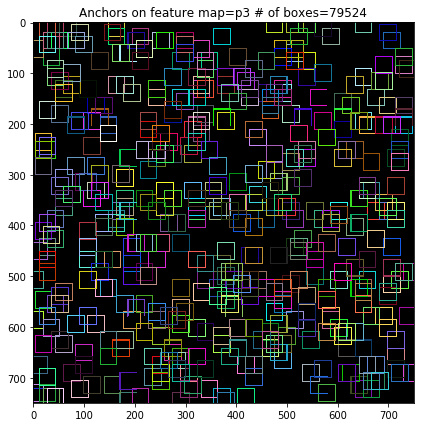

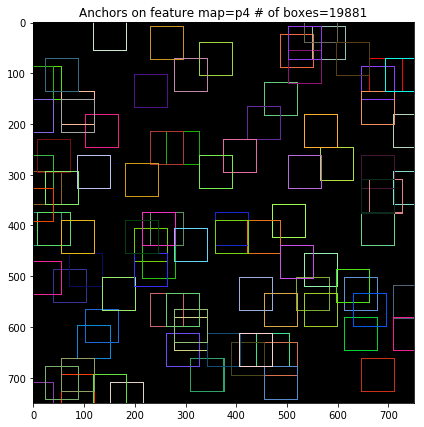

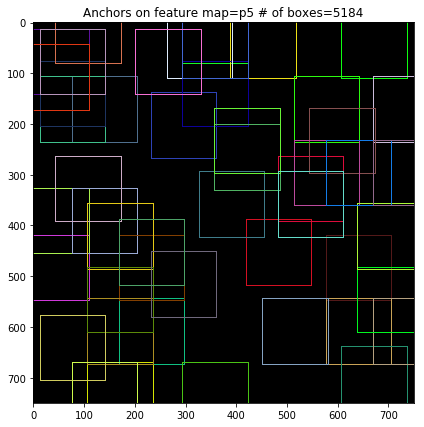

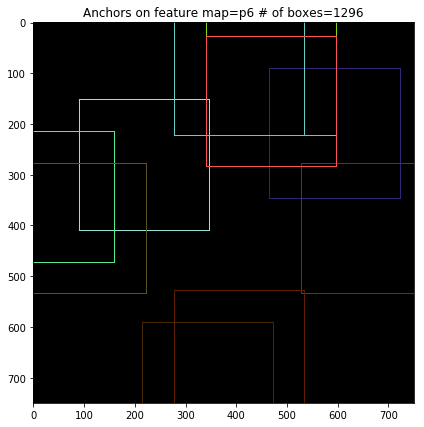

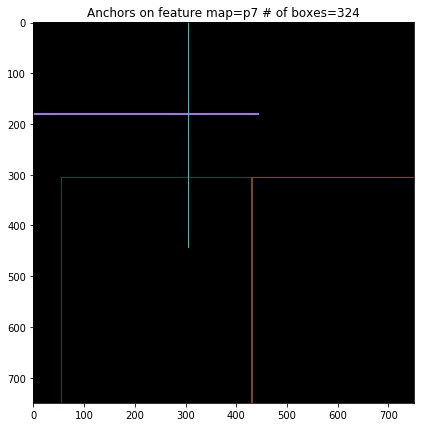

In [21]:
encoder = DataEncoder()
encoder.anchor_areas = [32*32., 64*64., 128*128., 256*256., 512 * 512.]  # p3 -> p7
encoder.aspect_ratios = [1., 1. , 1.]
encoder.scale_ratios = [1., 1., 1.]
encoder.anchor_wh = encoder._get_anchor_wh()

anchors, anchors_per_fm = encoder._get_anchor_boxes(T(im_size))
anchors = change_box_order(anchors, 'xywh2xyxy')


feature_map_names = ['p3', 'p4', 'p5', 'p6', 'p7']
n_anchors = [500,100,50,10,5]
for fm_name, boxes, i in zip(feature_map_names, anchors_per_fm, n_anchors):
    number_of_anchors_total = len(boxes)
    anch = np.array(change_box_order(boxes, 'xywh2xyxy'))
    rnd_ix = np.random.randint(0, len(anch), i)
    rnd_anchors = np.array(anch[rnd_ix, :])
    canvas = Image.fromarray(np.uint8(np.zeros(im_size + (3,))))
    bbs = [ia.BoundingBox(*b) for b in rnd_anchors]
    for box in bbs:
        canvas = box.draw_on_image(
            canvas, color=np.random.rand(3) * 255, thickness=2, 
        )  
        
    plt.figure(figsize=(7,7))
    plt.title("Anchors on feature map={} # of boxes={}".format(fm_name, number_of_anchors_total))
    plt.imshow(canvas)


tensor([[-7.3243e+00, -1.8638e+01,  1.5303e+01,  2.6617e+01],
        [-1.0265e+01, -2.4519e+01,  1.8244e+01,  3.2498e+01],
        [-1.3970e+01, -3.1929e+01,  2.1949e+01,  3.9908e+01],
        ...,
        [ 3.2546e+02,  5.0648e+02,  1.0495e+03,  8.6852e+02],
        [ 2.3136e+02,  4.5943e+02,  1.1436e+03,  9.1557e+02],
        [ 1.1280e+02,  4.0015e+02,  1.2622e+03,  9.7485e+02]])
(95, 4)


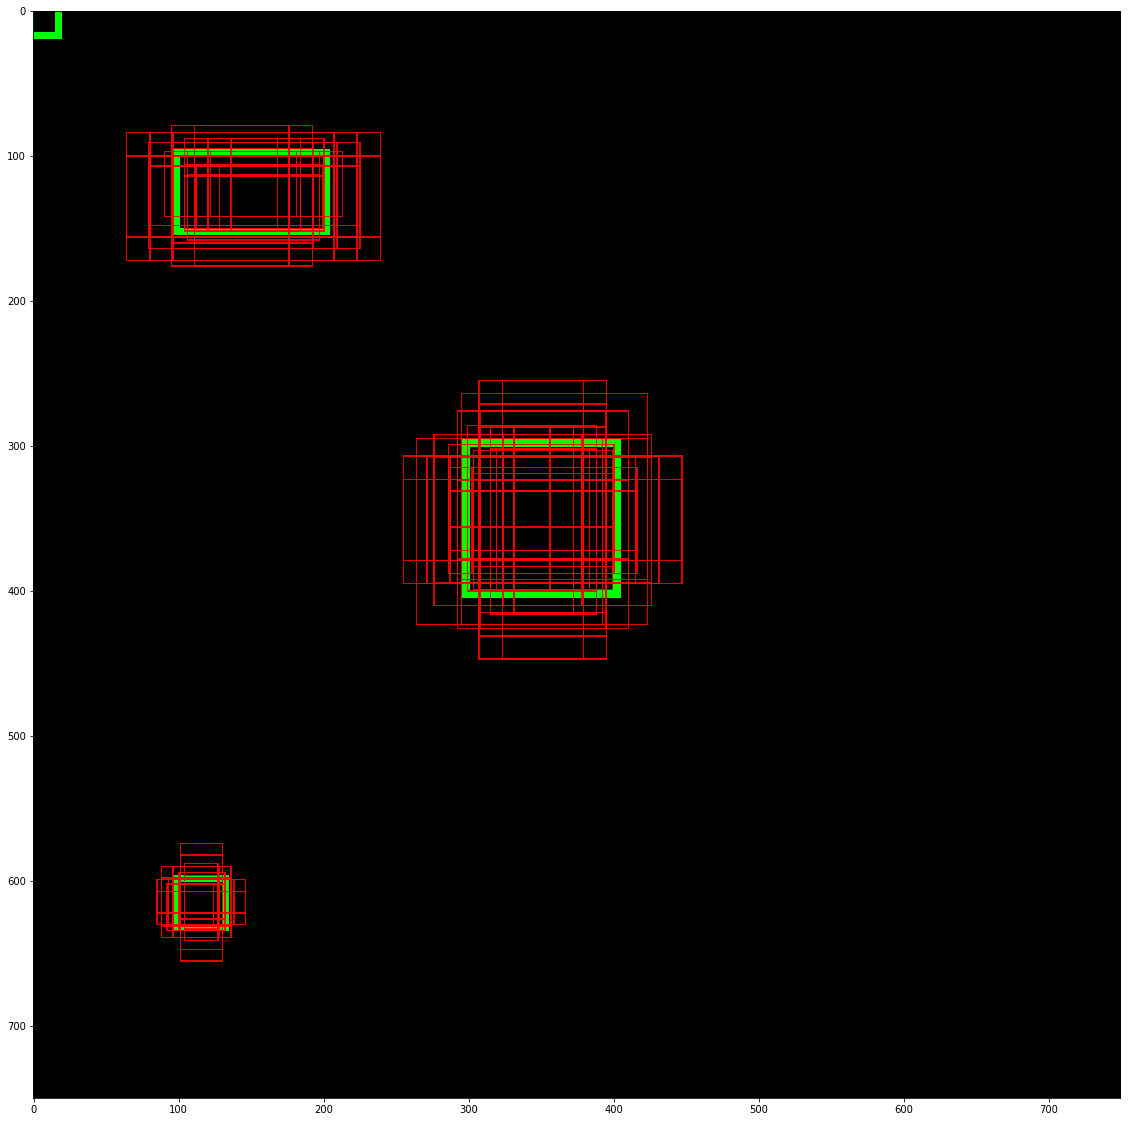

In [2]:
encoder = DataEncoder()
anchors,_ = encoder._get_anchor_boxes(T(im_size))
anchors = change_box_order(anchors, 'xywh2xyxy')
print(anchors)
anchors = np.array(anchors)
some_box = T([[0,0,15,15], [100,100,200,150],[300,300,400,400], [100,600, 130, 630]])
input_size = T(im_size)
labels = T([0,0,0,0])
loc_targets, cls_targets = encoder.encode(some_box, labels, input_size)


matched_anchors = anchors[np.array(cls_targets>0.9).astype(bool),:]


real_bbs_on_image = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*b) for b in some_box], shape=im_size)

matched_anchors_on_image = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*b) for b in matched_anchors], shape=im_size)

print(matched_anchors.shape)

canvas = np.ones(im_size+(3,))
image = Image.fromarray(np.uint8(canvas))
image = real_bbs_on_image.draw_on_image(image, thickness=5)
image = matched_anchors_on_image.draw_on_image(image, color=[255,0,0], thickness=1, alpha=0.9)

plt.figure(figsize=(20,20))
plt.imshow(image)


In [4]:
np.array(cls_targets) > 0.1

array([False, False, False, ..., False, False, False])

In [6]:
print(matched_anchors)
print(some_box)


[[36.       76.       35.918785 71.83757 ]]

  0   0  30  30
[torch.FloatTensor of size 1x4]



In [168]:
# from utils import box_iou
# a = T([[0,0,30,30]])
# b = T([36, 76, 35, 71])
box_iou(T(matched_anchors), T([[428,516,32,32]]))

def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
 
	# compute the area of intersection rectangle
	interArea = (xB - xA + 1) * (yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou

bb_intersection_over_union([0,0,30,30], [36, 76, 35, 71])

0.30570652173913043

In [60]:
np.array(box_iou(some_box, anchors, ))[0]

array([-0., -0., -0., ...,  0.,  0., -0.], dtype=float32)

In [75]:
anchors[-50::, :]


array([[ 988.      , 1020.      ,   22.627417,   45.254833],
       [1012.      ,  996.      ,   45.254833,   22.627417],
       [ 996.      , 1012.      ,   22.627417,   45.254833],
       [1020.      , 1004.      ,   40.317474,   40.317474],
       [1004.      , 1020.      ,   40.317474,   40.317474],
       [1012.      , 1012.      ,   40.317474,   40.317474],
       [1020.      ,  988.      ,   32.      ,   32.      ],
       [ 988.      , 1020.      ,   32.      ,   32.      ],
       [1012.      ,  996.      ,   32.      ,   32.      ],
       [ 996.      , 1012.      ,   32.      ,   32.      ],
       [1004.      , 1004.      ,   32.      ,   32.      ],
       [1020.      , 1012.      ,   28.508759,   57.017517],
       [1012.      , 1020.      ,   57.017517,   28.508759],
       [1020.      , 1012.      ,   57.017517,   28.508759],
       [1012.      , 1020.      ,   28.508759,   57.017517],
       [1020.      ,  996.      ,   22.627417,   45.254833],
       [ 996.      , 102

In [80]:
small_anchors

array([[ 548.      ,   36.      ,   57.017517,   28.508759],
       [  36.      ,  548.      ,   28.508759,   57.017517],
       [ 240.      ,  208.      ,  161.2699  ,  161.2699  ],
       [ 208.      ,  240.      ,  161.2699  ,  161.2699  ],
       [ 376.      ,   56.      ,  143.67514 ,   71.83757 ],
       [  56.      ,  376.      ,   71.83757 ,  143.67514 ],
       [ 236.      ,   28.      ,   22.627417,   45.254833],
       [  28.      ,  236.      ,   45.254833,   22.627417],
       [ 424.      ,  104.      ,   57.017517,  114.035034],
       [ 104.      ,  424.      ,  114.035034,   57.017517],
       [ 152.      ,   56.      ,   45.254833,   90.50967 ],
       [  56.      ,  152.      ,   90.50967 ,   45.254833],
       [ 996.      ,   68.      ,   35.918785,   71.83757 ],
       [  68.      ,  996.      ,   71.83757 ,   35.918785],
       [ 364.      ,   68.      ,   28.508759,   57.017517],
       [  68.      ,  364.      ,   57.017517,   28.508759],
       [ 360.      ,   7

In [151]:
'''Encode object boxes and labels.'''
import math
import torch

from utils import meshgrid, box_iou, box_nms, change_box_order

def _get_anchor_boxes(input_size):
    '''Compute anchor boxes for each feature map.

    Args:
      input_size: (tensor) model input size of (w,h).

    Returns:
      boxes: (list) anchor boxes for each feature map. Each of size [#anchors,4],
                    where #anchors = fmw * fmh * #anchors_per_cell
    '''
    num_fms = 5
    fm_sizes = [(input_size/pow(2.,i+3)).ceil() for i in range(num_fms)]  # p3 -> p7 feature map sizes

    boxes = []
    for i in range(num_fms):
        fm_size = fm_sizes[i]
        grid_size = input_size / fm_size
        fm_w, fm_h = int(fm_size[0]), int(fm_size[1])
        xy = meshgrid(fm_w,fm_h) + 0.5  # [fm_h*fm_w, 2]
        xy = (xy*grid_size).view(fm_h,fm_w,1,2).expand(fm_h,fm_w,9,2)
        wh = self.anchor_wh[i].view(1,1,9,2).expand(fm_h,fm_w,9,2)
        box = torch.cat([xy,wh], 3)  # [x,y,w,h]
        boxes.append(box.view(-1,4))
    return torch.cat(boxes, 0), boxes


In [154]:
'''Encode object boxes and labels.'''
import math
import torch

from utils import meshgrid, box_iou, box_nms, change_box_order


class DataEncoder:
    def __init__(self):
        self.anchor_areas = [32*32., 64*64., 128*128., 256*256., 512*512.]  # p3 -> p7
        self.aspect_ratios = [1/2., 1/1., 2/1.]
        self.scale_ratios = [1., pow(2,1/3.), pow(2,2/3.)]
        self.anchor_wh = self._get_anchor_wh()

    def _get_anchor_wh(self):
        '''Compute anchor width and height for each feature map.

        Returns:
          anchor_wh: (tensor) anchor wh, sized [#fm, #anchors_per_cell, 2].
        '''
        anchor_wh = []
        for s in self.anchor_areas:
            for ar in self.aspect_ratios:  # w/h = ar
                h = math.sqrt(s/ar)
                w = ar * h
                for sr in self.scale_ratios:  # scale
                    anchor_h = h*sr
                    anchor_w = w*sr
                    anchor_wh.append([anchor_w, anchor_h])
        num_fms = len(self.anchor_areas)
        return torch.Tensor(anchor_wh).view(num_fms, -1, 2)

    def _get_anchor_boxes(self, input_size):
        '''Compute anchor boxes for each feature map.

        Args:
          input_size: (tensor) model input size of (w,h).

        Returns:
          boxes: (list) anchor boxes for each feature map. Each of size [#anchors,4],
                        where #anchors = fmw * fmh * #anchors_per_cell
        '''
        num_fms = len(self.anchor_areas)
        fm_sizes = [(input_size/pow(2.,i+3)).ceil() for i in range(num_fms)]  # p3 -> p7 feature map sizes

        boxes = []
        for i in range(num_fms):
            fm_size = fm_sizes[i]
            grid_size = input_size / fm_size
            fm_w, fm_h = int(fm_size[0]), int(fm_size[1])
            xy = meshgrid(fm_w,fm_h) + 0.5  # [fm_h*fm_w, 2]
            xy = (xy*grid_size).view(fm_h,fm_w,1,2).expand(fm_h,fm_w,9,2)
            wh = self.anchor_wh[i].view(1,1,9,2).expand(fm_h,fm_w,9,2)
            box = torch.cat([xy,wh], 3)  # [x,y,w,h]
            boxes.append(box.view(-1,4))
        return torch.cat(boxes, 0), boxes

    def encode(self, boxes, labels, input_size):
        '''Encode target bounding boxes and class labels.
        We obey the Faster RCNN box coder:
          tx = (x - anchor_x) / anchor_w
          ty = (y - anchor_y) / anchor_h
          tw = log(w / anchor_w)
          th = log(h / anchor_h)
        Args:
          boxes: (tensor) bounding boxes of (xmin,ymin,xmax,ymax), sized [#obj, 4].
          labels: (tensor) object class labels, sized [#obj,].
          input_size: (int/tuple) model input size of (w,h).
        Returns:
          loc_targets: (tensor) encoded bounding boxes, sized [#anchors,4].
          cls_targets: (tensor) encoded class labels, sized [#anchors,].
        '''
        input_size = torch.Tensor([input_size,input_size]) if isinstance(input_size, int) \
                     else torch.Tensor(input_size)
        anchor_boxes = self._get_anchor_boxes(input_size)
        boxes = change_box_order(boxes, 'xyxy2xywh')

        ious = box_iou(anchor_boxes, boxes, order='xywh')
        max_ious, max_ids = ious.max(1)
        boxes = boxes[max_ids]

        loc_xy = (boxes[:,:2]-anchor_boxes[:,:2]) / anchor_boxes[:,2:]
        loc_wh = torch.log(boxes[:,2:]/anchor_boxes[:,2:])
        loc_targets = torch.cat([loc_xy,loc_wh], 1)
        cls_targets = 1 + labels[max_ids]

        cls_targets[max_ious<0.5] = 0
        ignore = (max_ious>0.4) & (max_ious<0.5)  # ignore ious between [0.4,0.5]
        cls_targets[ignore] = -1  # for now just mark ignored to -1
        return loc_targets, cls_targets

    def decode(self, loc_preds, cls_preds, input_size):
        '''Decode outputs back to bouding box locations and class labels.

        Args:
          loc_preds: (tensor) predicted locations, sized [#anchors, 4].
          cls_preds: (tensor) predicted class labels, sized [#anchors, #classes].
          input_size: (int/tuple) model input size of (w,h).

        Returns:
          boxes: (tensor) decode box locations, sized [#obj,4].
          labels: (tensor) class labels for each box, sized [#obj,].
        '''
        CLS_THRESH = 0.05
        NMS_THRESH = 0.05


        input_size = torch.Tensor([input_size,input_size]) if isinstance(input_size, int) \
                     else torch.Tensor(input_size)
        anchor_boxes = self._get_anchor_boxes(input_size)

        loc_xy = loc_preds[:,:2]
        loc_wh = loc_preds[:,2:]

        xy = loc_xy * anchor_boxes[:,2:] + anchor_boxes[:,:2]
        wh = loc_wh.exp() * anchor_boxes[:,2:]
        boxes = torch.cat([xy-wh/2, xy+wh/2], 1)  # [#anchors,4]

        score, labels = cls_preds.sigmoid().max(1)          # [#anchors,]
        ids = score > CLS_THRESH
        ids = ids.nonzero().squeeze()             # [#obj,]
        keep = box_nms(boxes[ids], score[ids], threshold=NMS_THRESH)
        return boxes[ids][keep], labels[ids][keep]


In [157]:
de = DataEncoder()
a, boxes = de._get_anchor_boxes(T([600,600]))
change_box_order(boxes[4], 'xywh2xyxy')

In [169]:
boxes[4].shape

torch.Size([225, 4])

In [37]:
image

(750, 750, 3)

In [35]:
norm(image)

TypeError: tensor is not a torch image.

In [4]:
np.sqrt(79524)

282.0